In [40]:
!pip install bresenham



[notice] A new release of pip is available: 24.0 -> 24.2
[notice] To update, run: pip install --upgrade pip


In [41]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.pyplot import imshow
from PIL import Image, ImageOps, ImageFilter, ImageEnhance
from tqdm import tqdm
import math
from bresenham import bresenham as line_iter


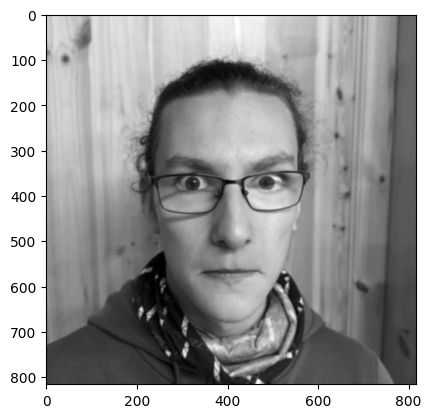

In [42]:
img = cv2.imread("../radim.png")
img = cv2.resize(img, (img.shape[0] * 2, img.shape[1] * 2))
# img = np.full_like(img, 0)
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
# cv2.line(img, (140, 140), (140, 140), 255, 150)

orig = img.copy()

canvas = np.full_like(img, 255)
# img_16 = img.astype(np.int16)
# canvas = np.full_like(img, 255)
canvas[0, 0] = 0
canvas[0, 1] = 255

imshow(img, cmap="gray")


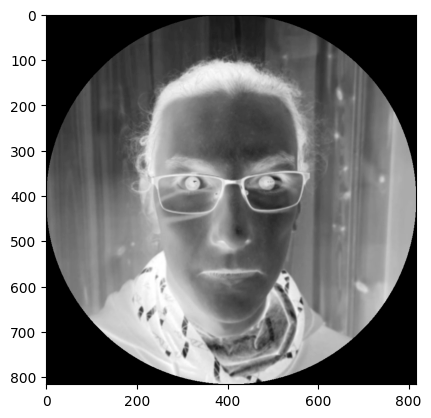

In [43]:
def create_circular_mask(h, w, center=None, radius=None):

    if center is None:  # use the middle of the image
        center = (int(w / 2), int(h / 2))
    if radius is None:  # use the smallest distance between the center and image walls
        radius = min(center[0], center[1], w - center[0], h - center[1])

    Y, X = np.ogrid[:h, :w]
    dist_from_center = np.sqrt((X - center[0]) ** 2 + (Y - center[1]) ** 2)

    mask = dist_from_center <= radius
    return mask


# preprocess
mask = create_circular_mask(img.shape[0], img.shape[1])
imgcircle = img.copy()
imgcircle[~mask] = 255
imginverted = np.full(img.shape, 255) - imgcircle

img = imginverted

imshow(img, cmap="gray")


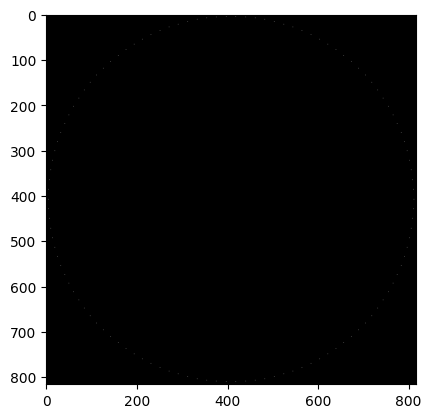

In [44]:
def generate_circle_points(center, radius, n):
    angles = np.linspace(0, 2 * np.pi, n, endpoint=False)
    points = [
        (center[0] + radius * np.cos(angle), center[1] + radius * np.sin(angle))
        for angle in angles
    ]
    return points


center = (img.shape[0] // 2, img.shape[1] // 2)
radius = min(img.shape) // 2 - 5
n = 118
circle_points = generate_circle_points(center, radius, n)

# Plot the points on the image
img_gray = np.full_like(img, 0)
for point in circle_points:
    img_gray[int(point[1]), int(point[0])] = 255

imshow(img_gray, cmap="gray")

spagat = [0]


In [45]:
for _ in tqdm(range(250)):
    from_pos = circle_points[spagat[-1]]
    best = [-1, -math.inf]
    for indx, to_pos in enumerate(circle_points):
        if indx == spagat[-1]:
            continue

        lajna = []

        for x, y in line_iter(
            int(from_pos[0]), int(from_pos[1]), int(to_pos[0]), int(to_pos[1])
        ):
            # print("herke")
            lajna.append(img[y, x])
            # brehem

        # print(lajna)
        lajna = np.array(lajna)

        error = np.sum(lajna)
        # print(error)

        if error > best[1]:
            # print(error, indx)
            best = [indx, error]
            bst = (from_pos, to_pos)
            best_lajna = lajna

        # break

    canvas_w_line = cv2.line(
        np.full_like(canvas, 0),
        tuple(map(int, from_pos)),
        tuple(map(int, circle_points[best[0]])),
        32,
        2,
    )

    canvas = cv2.subtract(canvas, canvas_w_line)
    img = cv2.subtract(img, canvas_w_line, dtype=cv2.CV_8U)

    # print(bst)
    # print(bst[0][1], bst[1][1])

    # print(round(bst[0][1]) == round(bst[1][1]))
    # plt.plot(best_lajna)
    # print(spagat[-1], best)
    # cary[(start, best[0])] += 1
    spagat.append(best[0])
    start = best[0]


100%|██████████| 250/250 [00:04<00:00, 50.69it/s]


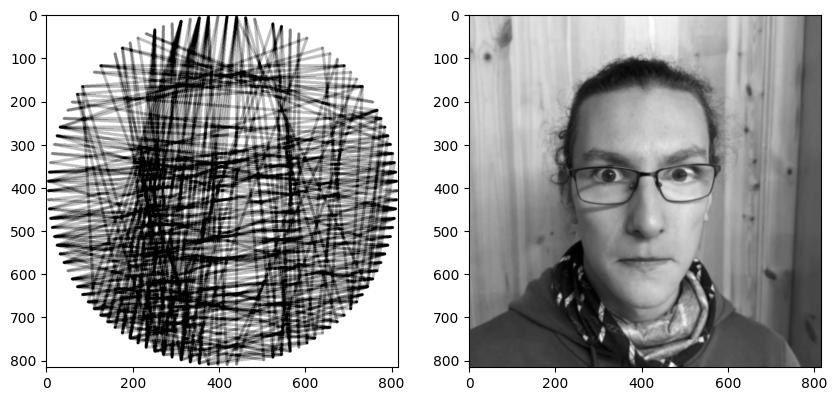

In [46]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
imshow(
    canvas,
    cmap="gray",
)
plt.subplot(1, 2, 2)
imshow(orig, cmap="gray")
